# Chapter 3 Part 2<br>Parameter Optimization with Surprise
## Dawei Wang

For this part you will experiment with parameter tuning for recommender systems implemented in Surprise. You will use the "review.csv" file from Yelp Core 5 distribution which includes ratings by users on various business establishments. The Yelp Core 5 data set is about 140k ratings, but it is fairly sparse (99.7%). Every user has rated at least five establishments and every establishment has at least five ratings. This data set is based on the Yelp challenge data set: https://www.kaggle.com/c/yelp-recsys-2013.



Pick three algorithms that are implemented in Surprise.

One neighborhood algorithm from:

    * KNNWithMeans: Item or User
    * KNNWithZScore: Item or User
    * KNNBaseline: Item or User

Two model-based algorithms from:

    * SVD
    * SVDpp
    * NMF
    * SlopeOne
    * CoClustering

Using the Yelp Core 5 data set, tune each algorithm to achieve the best performance on the RMSE metric.

Note that there are quite a few parameters for some algorithms. Keep careful notes about what parameters you tried and the results that you got. The GridSearchCV method in Surprise can be useful for this purpose. You do not need to include your code and full outputs for parameter tuning, but you'll need to submit a separate report detailing what you tried (see below).

After tuning your algorithm and determining the best parameters for each algorithm, create a Jupyter notebook showing a 5-fold CV comparison using the best parameters for each. Include a plot comparing the RMSE values.

Important Note: A better experimental methodology (which we are not using here) would be to hold out a validation set for evaluation and tune the algorithms on the training portion of the data. This is the proper evaluation methodology that you should use in more realistic situations (including the class project).


In [138]:
import os
import matplotlib
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import re
import nltk      
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from matplotlib import pyplot as plt
from platform import python_version
from scipy.spatial.distance import cosine, correlation
from sklearn.metrics import mean_squared_error, mean_absolute_error

pd.set_option('max_columns',200)
pd.set_option('display.precision',2)

print('Version list\n')
print('python',python_version())
print(np.__name__, np.__version__)
print(pd.__name__, pd.__version__)
print(sp.__name__, sp.__version__)
print(sns.__name__, sns.__version__)
print(matplotlib.__name__, matplotlib.__version__)
print(nltk.__name__, nltk.__version__)

Version list

python 3.9.7
numpy 1.22.2
pandas 1.3.5
scipy 1.7.3
seaborn 0.11.2
matplotlib 3.5.1
nltk 3.7


In [139]:
from surprise import Dataset, Reader, accuracy
from surprise import KNNBaseline, KNNWithMeans, KNNWithZScore,SVD, SVDpp, NMF, SlopeOne, SVDpp, CoClustering
from surprise.model_selection import cross_validate, GridSearchCV, train_test_split

In [140]:
os.chdir('/Users/daweiwang/Desktop/CSC 577/Assignments')
df = pd.read_csv('review.csv',header=None)
df = df.rename(columns ={0:'u_id',1:'b_id',2:'ratings'})

In [10]:
df 

,u_id,b_id,ratings
0,10000,0,5
1,10001,1,5
2,10002,2,5
3,10003,3,4
4,10004,4,5
...,...,...,...
141449,14909,1790,5
141450,13002,154,1
141451,10521,498,3
141452,15032,3315,2


In [12]:
print('Rating Scale')
print('Max:',df.ratings.max())
print('Min:',df.ratings.min())

Rating Scale
Max: 5
Min: 1


In [141]:
# Rating_scale 1-5
reader = Reader(rating_scale=(1, 5))
# Load data 
data = Dataset.load_from_df(df[['u_id','b_id','ratings']], reader)

In [142]:
knnbasic_cv = cross_validate(KNNBaseline(), data, cv=5, n_jobs=5, verbose=False)
knnmeans_cv = cross_validate(KNNWithMeans(), data, cv=5, n_jobs=5, verbose=False)
knnzscore_cv = cross_validate(KNNWithZScore(), data, cv=5, n_jobs=5, verbose=False)
svd_cv = cross_validate(SVD(), data, cv=5, n_jobs=5, verbose=False)
svdpp_cv = cross_validate(SVDpp(), data, cv=5, n_jobs=5, verbose=False)
nmf_cv = cross_validate(NMF(), data, cv=5, n_jobs=5, verbose=False)
slope_cv = cross_validate(SlopeOne(), data, cv=5, n_jobs=5, verbose=False)
cocluster_cv = cross_validate(CoClustering(), data, cv=5, n_jobs=5, verbose=False)

## Get the general idea of performances of all algorithms

In [145]:
RMSE = pd.DataFrame(columns=['Algorithm','RMSE'])
algo=[knnbasic_cv, knnmeans_cv, knnzscore_cv, svd_cv, svdpp_cv, nmf_cv, slope_cv, cocluster_cv]
name = ['KNN Baseline', 'KNN Means', 'KNN Zscore', 'SVD', 'SVD++', 'NMF', 'Slope One', 'Coclustering']
for i in range(len(algo)):
    RMSE.loc[i]=[name[i],algo[i]['test_rmse'].mean()]
    

In [146]:
RMSE

,Algorithm,RMSE
0,KNN Baseline,1.06
1,KNN Means,1.09
2,KNN Zscore,1.09
3,SVD,1.02
4,SVD++,1.02
5,NMF,1.12
6,Slope One,1.11
7,Coclustering,1.09


Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


### We can see the best perfomance was from SVD and SVD++  
### Next, try grid search on these two algorithms 

In [50]:
svd_param_grid = {'n_factors': [60,100,140],
                  'n_epochs': [5, 15, 25], 
                  'lr_all': [0.001, 0.005, 0.009],
                  'reg_all': [0.2, 0.4, 0.6]}
# epochs The number of iteration of the SGD procedure
# lr_all: The learning rate for all parameters. Default is 0.005.
# reg_all: The regularization term for all parameters. Default is 0.02.
# Complexity O(n ^3)

svdpp = GridSearchCV(SVDpp, svd_param_grid, measures=['rmse'], cv=3, n_jobs=5)
svdpp.fit(data)

svd = GridSearchCV(SVD, svd_param_grid, measures=['rmse'], cv=3, n_jobs=5)
svd.fit(data)

### The best result for these two algorithms listed below

In [120]:
print(round(svd.best_score['rmse'], 4))
print(svd.best_params['rmse'])

1.0136
{'n_factors': 60, 'n_epochs': 25, 'lr_all': 0.005, 'reg_all': 0.2}


In [119]:
print(round(svdpp.best_score['rmse'], 4))
print(svdpp.best_params['rmse'])

1.0193
{'n_factors': 60, 'n_epochs': 25, 'lr_all': 0.005, 'reg_all': 0.2}


## Manual Search
### To avoid long waiting and accident interruptions, here I tried to split the dataset and use combinations of parameters to get the best ones

In [63]:
train, test = train_test_split(data, test_size=.20)

### The parameter sets were based on the grid search results

In [74]:
n_factors = [45,60,75]
n_epochs = [20, 25, 30]
lr_all = [0.003, 0.005, 0.007]
reg_all = [0.1, 0.2, 0.3]
# parameters = 3^4 =81
from itertools import product
val = [n_factors,n_epochs,lr_all,reg_all]
para = []
acc = []
for i in product(*val):
    para.append(i)
    algo = SVD(n_factors = i[0], n_epochs = i[1], lr_all=i[2], reg_all=i[3] )
    algo.fit(train)
    pred = algo.test(test)
    acc.append(accuracy.rmse(pred))

RMSE: 1.0206
RMSE: 1.0209
RMSE: 1.0226
RMSE: 1.0155
RMSE: 1.0150
RMSE: 1.0164
RMSE: 1.0141
RMSE: 1.0129
RMSE: 1.0143
RMSE: 1.0170
RMSE: 1.0179
RMSE: 1.0195
RMSE: 1.0132
RMSE: 1.0140
RMSE: 1.0146
RMSE: 1.0142
RMSE: 1.0130
RMSE: 1.0138
RMSE: 1.0160
RMSE: 1.0163
RMSE: 1.0174
RMSE: 1.0141
RMSE: 1.0133
RMSE: 1.0142
RMSE: 1.0159
RMSE: 1.0129
RMSE: 1.0137
RMSE: 1.0204
RMSE: 1.0215
RMSE: 1.0233
RMSE: 1.0149
RMSE: 1.0155
RMSE: 1.0167
RMSE: 1.0150
RMSE: 1.0142
RMSE: 1.0145
RMSE: 1.0177
RMSE: 1.0182
RMSE: 1.0193
RMSE: 1.0144
RMSE: 1.0139
RMSE: 1.0154
RMSE: 1.0152
RMSE: 1.0130
RMSE: 1.0141
RMSE: 1.0162
RMSE: 1.0168
RMSE: 1.0173
RMSE: 1.0139
RMSE: 1.0131
RMSE: 1.0143
RMSE: 1.0157
RMSE: 1.0129
RMSE: 1.0139
RMSE: 1.0214
RMSE: 1.0214
RMSE: 1.0231
RMSE: 1.0166
RMSE: 1.0159
RMSE: 1.0175
RMSE: 1.0145
RMSE: 1.0136
RMSE: 1.0148
RMSE: 1.0188
RMSE: 1.0179
RMSE: 1.0201
RMSE: 1.0147
RMSE: 1.0140
RMSE: 1.0152
RMSE: 1.0154
RMSE: 1.0135
RMSE: 1.0136
RMSE: 1.0167
RMSE: 1.0167
RMSE: 1.0178
RMSE: 1.0142
RMSE: 1.0132

### The best  RMSE is 1.0129

In [77]:
min(acc)

1.0128613232314272

In [82]:
best = para[acc.index(min(acc))]

### Here we can see, the best parameter set gives Mean RMSE 1.0144 on 5-fold cross validation 

In [83]:
algo = SVD(n_factors = best[0], n_epochs = best[1], lr_all = best[2], reg_all = best[3] )

SVD_best = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0225  1.0153  1.0082  1.0142  1.0118  1.0144  0.0047  
Fit time          3.71    3.54    3.45    3.88    3.63    3.64    0.15    
Test time         0.08    0.15    0.08    0.16    0.08    0.11    0.04    


### Then Try the same thing with SVD++

In [85]:
n_factors = [45,60,75]
n_epochs = [10, 15, 20]
lr_all = [0.009,0.011,0.013]
reg_all = [0.1, 0.2, 0.3]
# parameters = 3^4 =81
from itertools import product
val = [n_factors,n_epochs,lr_all,reg_all]
para = []
acc = []
for i in product(*val):
    para.append(i)
    algo = SVDpp(n_factors = i[0], n_epochs = i[1], lr_all=i[2], reg_all=i[3] )
    algo.fit(train)
    pred = algo.test(test)
    acc.append(accuracy.rmse(pred))

### The best RMSE for SVD++ is 1.0164

In [129]:
min(acc)

1.0163515956283986

In [130]:
best = para[acc.index(min(acc))]
best

(60, 20, 0.009, 0.2)


In [133]:
algo = SVDpp(n_factors = best[0], n_epochs = best[1], lr_all = best[2], reg_all = best[3] )

SVDpp_best = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0208  1.0151  1.0070  1.0123  1.0187  1.0148  0.0049  
Fit time          79.54   79.87   79.89   80.12   80.61   80.01   0.35    
Test time         0.71    0.73    0.85    0.73    0.93    0.79    0.09 

### The best RMSE for SVD++ is 1.0148 

### For KNN, compare all three algorithms (KNN Baseline, KNN with means, KNN with Z-score) with different k 

In [93]:
acc1,acc2,acc3 = [],[],[]

for k in range(1,51):
    algo1 = KNNBaseline(k=k)
    algo1.fit(train)
    pred1 = algo1.test(test)
    acc1.append(accuracy.rmse(pred1))
    
    algo2 = KNNWithMeans(k=k)
    algo2.fit(train)
    pred2 = algo2.test(test)
    acc2.append(accuracy.rmse(pred2))
    
    algo3 = KNNWithZScore(k=k)
    algo3.fit(train)
    pred3 = algo3.test(test)
    acc3.append(accuracy.rmse(pred3))

    

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.3212
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.3135
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.3251
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.1844
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.1942
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.2067
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.1353
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.1501
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.1601
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.1100
Computing the ms

RMSE: 1.0601
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0812
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0878
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0601
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0811
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0878
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0600
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0810
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0877
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0599
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0809
Computing the msd similarity matri

In [94]:
print(min(acc1))
print(min(acc2))
print(min(acc3))

1.0590937787561099
1.080128771708165
1.0868057393481272


In [106]:
print(acc1.index(min(acc1)))
print(acc2.index(min(acc2)))
print(acc3.index(min(acc3)))

49
49
49


### For all these three, k = 50 has the best RMSE. Since the best k is the max k in the parameter set, try to enlarge k and test the RMSE

In [107]:
l = list(range(50,80,5))
acc21,acc22,acc23 = [],[],[]
for k in range(50,80,5):
    algo1 = KNNBaseline(k=k)
    algo1.fit(train)
    pred1 = algo1.test(test)
    acc21.append(accuracy.rmse(pred1))
    
    algo2 = KNNWithMeans(k=k)
    algo2.fit(train)
    pred2 = algo2.test(test)
    acc22.append(accuracy.rmse(pred2))
    
    algo3 = KNNWithZScore(k=k)
    algo3.fit(train)
    pred3 = algo3.test(test)
    acc23.append(accuracy.rmse(pred3))


Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0591
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0801
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0868
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0591
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0801
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0868
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0590
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0800
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0867
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0590
Computing the ms

In [108]:
print(min(acc21))
print(min(acc22))
print(min(acc23))
print(acc21.index(min(acc21)))
print(acc22.index(min(acc22)))
print(acc23.index(min(acc23)))

1.0589184038706616
1.0799271512699997
1.0866214464711343
5
5
5


In [110]:
l[5]

75

### We can see, k = 75 has the best performance, but the difference is less than 0.3%.  Next part is an experiment for narrow down best k 

In [111]:
l3 = list(range(70,80))
acc31 = []
for k in range(70,80):
    algo1 = KNNBaseline(k=k)
    algo1.fit(train)
    pred1 = algo1.test(test)
    acc31.append(accuracy.rmse(pred1))
    

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0589
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0589
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0589
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0589
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0589
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0589
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0589
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0589
Estimating biases using als...
Computing the msd similarity matr

In [112]:
print(min(acc31))
print(acc31.index(min(acc31)))

1.0588894944659317
9


In [113]:
l3[9]

79

In [121]:
algo = KNNBaseline(k=75 )

KNN_best = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=True)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0602  1.0592  1.0512  1.0623  1.0636  1.0593  0.0043  
Fit time          0.93    0.91    0.97    0.93    0.92    0.93    0.02    
Test time         1.36    1.40    1.36    1.32    1.39    1.37    0.03    


### As expected, the best perfomance for KNN inspired algorithms are KNN baseline and the best K is around 75 and best RMSE is 1.0593

### CoClustering 

In [ ]:
# n_cltr_u (int) – Number of user clusters. Default is 3.
# n_cltr_i (int) – Number of item clusters. Default is 3.
# n_epochs (int) – Number of iteration of the optimization loop. Default is 20.

In [117]:
n_cltr_u  = [3,7,11,15]
n_cltr_i = [3,7,11,15]
n_epochs = [15, 20, 25]

from itertools import product
val = [n_cltr_u,n_cltr_i,n_epochs]
para = []
acc = []
for i in product(*val):
    para.append(i)
    algo = CoClustering(n_cltr_u = i[0], n_cltr_i = i[1], n_epochs = i[2])
    algo.fit(train)
    pred = algo.test(test)
    acc.append(accuracy.rmse(pred))

/var/folders/d4/s3dpbdr15qq9g4_2mn0lm1kc0000gn/T/ipykernel_13344/3284604495.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  algo.fit(train)


RMSE: 1.0787
RMSE: 1.0801
RMSE: 1.0802
RMSE: 1.0928
RMSE: 1.0950
RMSE: 1.0956
RMSE: 1.0990
RMSE: 1.0970
RMSE: 1.1039
RMSE: 1.1006
RMSE: 1.1000
RMSE: 1.1069
RMSE: 1.1031
RMSE: 1.1002
RMSE: 1.1011
RMSE: 1.1092
RMSE: 1.1146
RMSE: 1.1132
RMSE: 1.1201
RMSE: 1.1206
RMSE: 1.1181
RMSE: 1.1266
RMSE: 1.1204
RMSE: 1.1226
RMSE: 1.1068
RMSE: 1.1093
RMSE: 1.1058
RMSE: 1.1247
RMSE: 1.1219
RMSE: 1.1226
RMSE: 1.1242
RMSE: 1.1314
RMSE: 1.1292
RMSE: 1.1359
RMSE: 1.1284
RMSE: 1.1404
RMSE: 1.1080
RMSE: 1.1126
RMSE: 1.1147
RMSE: 1.1290
RMSE: 1.1316
RMSE: 1.1350
RMSE: 1.1322
RMSE: 1.1445
RMSE: 1.1371
RMSE: 1.1385
RMSE: 1.1349
RMSE: 1.1414


In [122]:
min(acc)

1.0786870642272215

In [123]:
para[acc.index(min(acc))]

(3, 3, 15)

### Move to smaller parameters due to the best result was at the smallest parameters 

In [124]:
n_cltr_u  = [1,2,3]
n_cltr_i = [1,2,3]
n_epochs = [10, 15, 20]

from itertools import product
val = [n_cltr_u,n_cltr_i,n_epochs]
para = []
acc = []
for i in product(*val):
    para.append(i)
    algo = CoClustering(n_cltr_u = i[0], n_cltr_i = i[1], n_epochs = i[2])
    algo.fit(train)
    pred = algo.test(test)
    acc.append(accuracy.rmse(pred))

/var/folders/d4/s3dpbdr15qq9g4_2mn0lm1kc0000gn/T/ipykernel_13344/1588292293.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  algo.fit(train)


RMSE: 1.0483
RMSE: 1.0483
RMSE: 1.0483
RMSE: 1.0483
RMSE: 1.0483
RMSE: 1.0483
RMSE: 1.0483
RMSE: 1.0483
RMSE: 1.0483
RMSE: 1.0483
RMSE: 1.0483
RMSE: 1.0483
RMSE: 1.0665
RMSE: 1.0665
RMSE: 1.0663
RMSE: 1.0735
RMSE: 1.0712
RMSE: 1.0725
RMSE: 1.0483
RMSE: 1.0483
RMSE: 1.0483
RMSE: 1.0724
RMSE: 1.0754
RMSE: 1.0754
RMSE: 1.0737
RMSE: 1.0694
RMSE: 1.0805


In [125]:
para[acc.index(min(acc))]

(1, 1, 10)

In [127]:
n_epoch = list(range(1,10))

from itertools import product
val = [n_cltr_u,n_cltr_i,n_epochs]
para = []
acc = []
for i in range(len(n_epoch)):
    algo = CoClustering(n_cltr_u = 1, n_cltr_i = 1, n_epochs = n_epoch[i])
    algo.fit(train)
    pred = algo.test(test)
    acc.append(accuracy.rmse(pred))

/var/folders/d4/s3dpbdr15qq9g4_2mn0lm1kc0000gn/T/ipykernel_13344/76367048.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  algo.fit(train)


RMSE: 1.0483
RMSE: 1.0483
RMSE: 1.0483
RMSE: 1.0483
RMSE: 1.0483
RMSE: 1.0483
RMSE: 1.0483
RMSE: 1.0483
RMSE: 1.0483


In [131]:
algo = CoClustering(n_cltr_u = 1, n_cltr_i = 1, n_epochs = 10)

SVDpp_best = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm CoClustering on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0492  1.0564  1.0489  1.0464  1.0583  1.0518  0.0046  
Fit time          0.68    0.65    0.65    0.64    0.66    0.65    0.01    
Test time         0.15    0.06    0.15    0.07    0.07    0.10    0.04    


### The best RMSE for CoClustering is 1.0518 on 5-fold cross validation

In [135]:
comp = pd.DataFrame({'Models':['SVD','SVD++','KNN Baseline','CoClustering'],'RMSE':[1.0144,1.0148 ,1.0593, 1.0518]})

[Text(0.5, 1.0, 'RMSE on different models')]

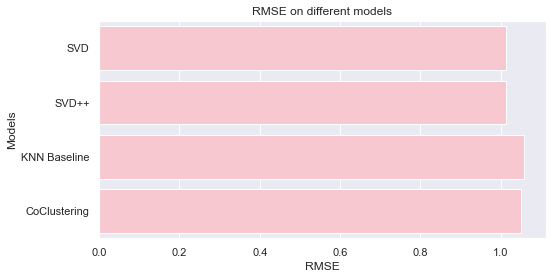

In [137]:
sns.set(rc = {'figure.figsize':(8,4)})
sns.barplot(x = "RMSE",y = "Models", data = comp, color = "pink" ).set(title = "RMSE on different models")

# THE END